# Task 1: Language model inference

The goal if this first task is to familiarize yourself with the huggingface transformers and dataset libraries. You will learn how to load and tokenize a dataset, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [ ]:
# import dependencies
import matplotlib.pyplot as plt
import numpy as np
import torch

from datasets import load_dataset, load_dataset_builder, get_dataset_split_names, get_dataset_config_names
from transformers import XGLMTokenizer, XGLMTokenizerFast, XGLMForCausalLM, AutoModelForCausalLM, AutoTokenizer, GenerationConfig, GPT2Model

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Explore dataset

In [2]:
DATA_SET_NAME = "facebook/flores" # specify dataset name
MODEL_NAME = "facebook/xglm-564M" # specify model name
# MODEL_NAME = "gpt2" # specify model name

In [3]:
# Explore a dataset

# covered language codes can be found here: https://github.com/openlanguagedata/flores?tab=readme-ov-file#language-coverage

ds_builder = load_dataset_builder("facebook/flores", "deu_Latn", trust_remote_code=True)
print(ds_builder.info.description) # print the dataset description

The creation of FLORES-200 doubles the existing language coverage of FLORES-101. 
Given the nature of the new languages, which have less standardization and require 
more specialized professional translations, the verification process became more complex. 
This required modifications to the translation workflow. FLORES-200 has several languages 
which were not translated from English. Specifically, several languages were translated 
from Spanish, French, Russian and Modern Standard Arabic. Moreover, FLORES-200 also 
includes two script alternatives for four languages. FLORES-200 consists of translations 
from 842 distinct web articles, totaling 3001 sentences. These sentences are divided 
into three splits: dev, devtest, and test (hidden). On average, sentences are approximately 
21 words long.



In [4]:
# print the features (columns) of the dataset
# TODO: your code goes here
print("Features:")
for features in ds_builder.info.features:
    print(features)

Features:
id
URL
domain
topic
has_image
has_hyperlink
sentence


In [5]:
# get the available splits
# TODO: your code goes here
print("Available splits:")
for split in ds_builder.info.splits:
    print(split)

Available splits:
dev
devtest


## Load data, tokenize, and batchify

In [6]:
# specify languages
LANGUAGES = [
    "eng_Latn",
    "spa_Latn",
    "ita_Latn",
    "deu_Latn",
    "arb_Arab",
    "tel_Telu",
    "tam_Taml",
    "quy_Latn"
]

In [7]:
# load flores data for each language
# TODO: your code goes here
data = {}
for lang in LANGUAGES:
    data[lang] = load_dataset("facebook/flores", lang, trust_remote_code=True)

In [8]:
# let's look at the English subset
# TODO: your code goes here
print(data["eng_Latn"])

DatasetDict({
    dev: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence'],
        num_rows: 997
    })
    devtest: Dataset({
        features: ['id', 'URL', 'domain', 'topic', 'has_image', 'has_hyperlink', 'sentence'],
        num_rows: 1012
    })
})


In [9]:
# let's look at an individal sample from the dataset
# TODO: your code goes here
for feature, value in data["eng_Latn"]["dev"][0].items():
    print(f"{feature}: {value}")

id: 1
URL: https://en.wikinews.org/wiki/Scientists_say_new_medical_diagnostic_chip_can_sort_cells_anywhere_with_an_inkjet
domain: wikinews
topic: health
has_image: 0
has_hyperlink: 0
sentence: On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.


In [10]:
# tokenize the data

# load a pre-trained tokenizer from the huggingface hub
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# gpt2 does not have a padding token, so we have to add it manually
if MODEL_NAME == "gpt2":
    tokenizer.add_special_tokens({'pad_token': tokenizer.unk_token})

# specify the tokenization function
def tokenization(example):
    # fill in here
    tokenized = tokenizer(example["sentence"], return_tensors="pt", padding='max_length', truncation=True)
    return tokenized
    pass

# TODO: your code goes here
tokenized_data = {}
for lang in LANGUAGES:
    tokenized_data[lang] = data[lang].map(tokenization)


Map:   0%|          | 0/1012 [00:00<?, ? examples/s]

In [11]:
# let's take a look at a tokenized sample
# TODO: your code goes here
for feature, value in tokenized_data["eng_Latn"]["dev"][0].items():
    print(f"{feature}: {value}")

id: 1
URL: https://en.wikinews.org/wiki/Scientists_say_new_medical_diagnostic_chip_can_sort_cells_anywhere_with_an_inkjet
domain: wikinews
topic: health
has_image: 0
has_hyperlink: 0
sentence: On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.
input_ids: [[2, 1504, 28488, 4, 140003, 501, 32, 200884, 6073, 9512, 48, 88230, 76168, 32, 160597, 48, 11, 929, 55516, 35761, 155, 490, 9482, 89288, 235, 6950, 13, 11, 61368, 24049, 2005, 37295, 155, 490, 113, 213481, 72, 1117, 5885, 86368, 6929, 111288, 7, 73, 59298, 769, 743, 242, 5, 211, 5, 19015, 5129, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [12]:
# Define a function to filter the keys
def filter_keys(entry):
    return {key: entry[key] for key in ['input_ids', 'attention_mask']}


filtered_data_dev = {}
filtered_data_devtest = {}

# Iterate over each element in tokenized_data[lang]["dev"] and filter the keys
for lang in LANGUAGES:
    filtered_data_dev[lang] = [filter_keys(entry) for entry in tokenized_data[lang]["dev"]]
    filtered_data_devtest[lang] = [filter_keys(entry) for entry in tokenized_data[lang]["devtest"]]


In [13]:
for feature, value in filtered_data_dev["eng_Latn"][0].items():
    print(f"{feature}: {value}")

input_ids: [[2, 1504, 28488, 4, 140003, 501, 32, 200884, 6073, 9512, 48, 88230, 76168, 32, 160597, 48, 11, 929, 55516, 35761, 155, 490, 9482, 89288, 235, 6950, 13, 11, 61368, 24049, 2005, 37295, 155, 490, 113, 213481, 72, 1117, 5885, 86368, 6929, 111288, 7, 73, 59298, 769, 743, 242, 5, 211, 5, 19015, 5129, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [14]:
# construct a pytorch data loader for each dataset
BATCH_SIZE = 2 # for testing purposes, we start with a batch size of 2. You can change this later.

# TODO: your code goes here
data_loader_dev = {}
data_loader_devtest = {}
for lang in LANGUAGES:
    data_loader_dev[lang] = torch.utils.data.DataLoader(filtered_data_dev[lang], batch_size=BATCH_SIZE)
    data_loader_devtest[lang] = torch.utils.data.DataLoader(filtered_data_devtest[lang], batch_size=BATCH_SIZE)

## Load model

In [16]:
# load pre-trained model from the huggingface hub
model = AutoModelForCausalLM.from_pretrained(MODEL_NAME)
# put the model into evaluation mode
# TODO: your code goes here
model.eval()
model.to(device)

Some weights of XGLMForCausalLM were not initialized from the model checkpoint at facebook/xglm-564M and are newly initialized: ['model.embed_positions.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XGLMForCausalLM(
  (model): XGLMModel(
    (embed_tokens): Embedding(256008, 1024, padding_idx=1)
    (embed_positions): XGLMSinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-23): 24 x XGLMDecoderLayer(
        (self_attn): XGLMAttention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (activation_fn): GELUActivation()
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine

In [17]:
losses = {lang: [] for lang in LANGUAGES} # store per-batch losses for each language

# iterate over the dataset for each language and compute the cross-entropy loss per batch 
for lang in LANGUAGES:
    for batch in data_loader_dev[lang]:
        # Extract input IDs and attention masks
        input_ids = torch.stack([torch.cat(seq) for seq in batch['input_ids']]).to(device)
        attention_mask = torch.stack([torch.cat(seq) for seq in batch['attention_mask']]).to(device)
        
        # Shift input IDs to create target sequence
        target_ids = input_ids[:, 1:].contiguous()  # Shift by one token
        target_mask = attention_mask[:, 1:].contiguous()
        
        # Compute model outputs
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Get logits for next word prediction
        logits = outputs.logits[:, :-1].contiguous()  # Discard the last token's logits
        
        # Flatten the logits and target sequences
        logits_flat = logits.view(-1, logits.size(-1))
        target_ids_flat = target_ids.view(-1)
        target_mask_flat = target_mask.view(-1)
        
        # Filter out masked positions (where target_mask_flat == 0)
        masked_indices = target_mask_flat.nonzero().squeeze()
        logits_flat_masked = logits_flat.index_select(0, masked_indices)
        target_ids_flat_masked = target_ids_flat.index_select(0, masked_indices)
        
        # Compute cross-entropy loss
        loss = torch.nn.functional.cross_entropy(logits_flat_masked, target_ids_flat_masked)
        
        # Append loss to the list for the current language
        losses[lang].append(loss.item())
    print(f"Completed loss computation for {lang}")
    print(f"Average loss for {lang}: {np.mean(losses[lang])}")


Completed loss computation for eng_Latn
Average loss for eng_Latn: 7.845671591156709
Completed loss computation for spa_Latn
Average loss for spa_Latn: 8.024704102762716
Completed loss computation for ita_Latn
Average loss for ita_Latn: 8.422627958362709
Completed loss computation for deu_Latn
Average loss for deu_Latn: 8.448769486738827
Completed loss computation for arb_Arab
Average loss for arb_Arab: 8.464308300094757
Completed loss computation for tel_Telu
Average loss for tel_Telu: 8.385566569043544
Completed loss computation for tam_Taml
Average loss for tam_Taml: 8.182438421822742
Completed loss computation for quy_Latn
Average loss for quy_Latn: 8.568757355332613


## Visualize loss per language

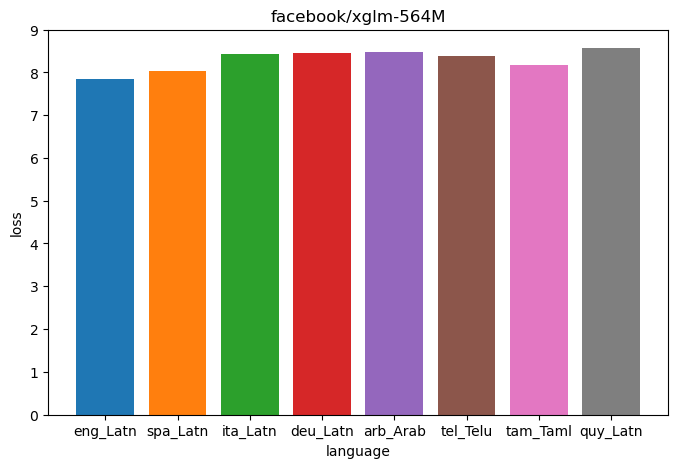

In [21]:
# create a figure
fig, axes = plt.subplots(figsize=(8, 5))

# create a bar plot for each langauge
# TODO: your code goes here
for lang, loss_list in losses.items():
    axes.bar(lang, sum(loss_list) / len(loss_list), label=lang)

# format plot
axes.set_xlabel("language") # x-axis label
axes.set_xticks(range(len(LANGUAGES))) # x-axis ticks
axes.set_xticklabels(losses.keys()) # x-axis tick labels
axes.set_ylabel("loss") # y-axis label
axes.set_ylim(0, 9) # range of y-axis
axes.set_title(MODEL_NAME); # title

## Comparing XGLM to GPT2

Your next task is to re-run the analysis above, but using `gpt2` as the pre-trained language model. For this exercise, focus on your native language, unless it's English or isn't covered by flores. In that case, pick another language that you can read well. 

Compare the language modeling loss of XGLM and GPT2. What do you observe? Investigate the differences in tokenization for XGLM and GPT2. What do you observe? How can the good (or bad) performance of GPT2 be explained?

In [24]:
# TODO: your code goes here
# Choosing hindi as the language

hindi_data = load_dataset("facebook/flores", "hin_Deva", trust_remote_code=True)

In [62]:
MODEL_2_NAME = "openai-community/gpt2" # specify model name

In [63]:
for feature, value in hindi_data["dev"][0].items():
    print(f"{feature}: {value}")

id: 1
URL: https://en.wikinews.org/wiki/Scientists_say_new_medical_diagnostic_chip_can_sort_cells_anywhere_with_an_inkjet
domain: wikinews
topic: health
has_image: 0
has_hyperlink: 0
sentence: सोमवार को, स्टैनफ़ोर्ड यूनिवर्सिटी स्कूल ऑफ़ मेडिसिन के वैज्ञानिकों ने एक नए डायग्नोस्टिक उपकरण के आविष्कार की घोषणा की जो कोशिकाओं को उनके प्रकार के आधार पर छाँट सकता है: एक छोटी प्रिंट करने योग्य चिप जिसे स्टैण्डर्ड इंकजेट प्रिंटर का उपयोग करके लगभग एक अमेरिकी सेंट के लिए निर्मित किया जा सकता है.


In [65]:
# tokenize the data

# load a pre-trained tokenizer from the huggingface hub
tokenizer = AutoTokenizer.from_pretrained(MODEL_2_NAME)

# gpt2 does not have a padding token, so we have to add it manually
# if MODEL_2_NAME == "gpt2":
tokenizer.add_special_tokens({'pad_token': tokenizer.unk_token})
    # tokenizer.pad_token = tokenizer.eos_token

# specify the tokenization function
def tokenization(example):
    # fill in here
    tokenized = tokenizer(example["sentence"], return_tensors="pt", padding='max_length', truncation=True)
    return tokenized
    pass

# TODO: your code goes here
tokenized_data_hindi = hindi_data.map(tokenization)


Map:   0%|          | 0/997 [00:00<?, ? examples/s]

Map:   0%|          | 0/1012 [00:00<?, ? examples/s]

In [66]:
# let's take a look at a tokenized sample
# TODO: your code goes here
for feature, value in tokenized_data_hindi["dev"][0].items():
    print(f"{feature}: {value}")

id: 1
URL: https://en.wikinews.org/wiki/Scientists_say_new_medical_diagnostic_chip_can_sort_cells_anywhere_with_an_inkjet
domain: wikinews
topic: health
has_image: 0
has_hyperlink: 0
sentence: सोमवार को, स्टैनफ़ोर्ड यूनिवर्सिटी स्कूल ऑफ़ मेडिसिन के वैज्ञानिकों ने एक नए डायग्नोस्टिक उपकरण के आविष्कार की घोषणा की जो कोशिकाओं को उनके प्रकार के आधार पर छाँट सकता है: एक छोटी प्रिंट करने योग्य चिप जिसे स्टैण्डर्ड इंकजेट प्रिंटर का उपयोग करके लगभग एक अमेरिकी सेंट के लिए निर्मित किया जा सकता है.
input_ids: [[11976, 116, 24231, 233, 11976, 106, 11976, 113, 48077, 11976, 108, 28225, 243, 24231, 233, 11, 28225, 116, 24231, 235, 11976, 253, 24231, 230, 11976, 101, 11976, 104, 11976, 120, 24231, 233, 11976, 108, 24231, 235, 11976, 94, 28225, 107, 24231, 224, 11976, 101, 11976, 123, 11976, 113, 11976, 108, 24231, 235, 11976, 116, 11976, 123, 11976, 253, 24231, 222, 28225, 116, 24231, 235, 11976, 243, 24231, 224, 11976, 110, 28225, 239, 11976, 104, 11976, 120, 28225, 106, 24231, 229, 11976, 94, 11976

In [67]:
filtered_data_hindi_dev = [filter_keys(entry) for entry in tokenized_data_hindi["dev"]]
filtered_data_hindi_devtest = [filter_keys(entry) for entry in tokenized_data_hindi["devtest"]]

In [68]:
for feature, value in filtered_data_hindi_dev[0].items():
    print(f"{feature}: {value}")

input_ids: [[11976, 116, 24231, 233, 11976, 106, 11976, 113, 48077, 11976, 108, 28225, 243, 24231, 233, 11, 28225, 116, 24231, 235, 11976, 253, 24231, 230, 11976, 101, 11976, 104, 11976, 120, 24231, 233, 11976, 108, 24231, 235, 11976, 94, 28225, 107, 24231, 224, 11976, 101, 11976, 123, 11976, 113, 11976, 108, 24231, 235, 11976, 116, 11976, 123, 11976, 253, 24231, 222, 28225, 116, 24231, 235, 11976, 243, 24231, 224, 11976, 110, 28225, 239, 11976, 104, 11976, 120, 28225, 106, 24231, 229, 11976, 94, 11976, 123, 11976, 116, 11976, 123, 11976, 101, 28225, 243, 24231, 229, 28225, 113, 24231, 230, 11976, 250, 24231, 235, 11976, 252, 48077, 11976, 101, 11976, 123, 11976, 243, 24231, 233, 11976, 224, 28225, 101, 24231, 229, 28225, 237, 11976, 243, 28225, 101, 11976, 237, 28225, 94, 48077, 11976, 107, 11976, 245, 24231, 235, 11976, 101, 24231, 233, 11976, 116, 24231, 235, 11976, 253, 11976, 123, 11976, 243, 28225, 231, 11976, 103, 11976, 243, 11976, 108, 11976, 96, 28225, 243, 24231, 229, 28225,

In [69]:
data_loader_hindi_dev = torch.utils.data.DataLoader(filtered_data_hindi_dev, batch_size=BATCH_SIZE)
data_loader_hindi_devtest = torch.utils.data.DataLoader(filtered_data_hindi_devtest, batch_size=BATCH_SIZE)

In [71]:
model_2 = GPT2Model.from_pretrained(MODEL_2_NAME)
model_2.eval()
# model_2.to(device)

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [77]:
losses_hindi = []
for batch in data_loader_hindi_dev:
    # Extract input IDs and attention masks
    input_ids = torch.stack([torch.cat(seq) for seq in batch['input_ids']])
    attention_mask = torch.stack([torch.cat(seq) for seq in batch['attention_mask']])
    
    # Shift input IDs to create target sequence
    target_ids = input_ids[:, 1:].contiguous()  # Shift by one token
    target_mask = attention_mask[:, 1:].contiguous()
    
    # Compute model outputs
    with torch.no_grad():
        outputs = model_2(input_ids=input_ids, attention_mask=attention_mask)

    # Get logits for next word prediction
    logits = outputs.logits[:, :-1].contiguous()  # Discard the last token's logits
    
    # Flatten the logits and target sequences
    logits_flat = logits.view(-1, logits.size(-1))
    target_ids_flat = target_ids.view(-1)
    target_mask_flat = target_mask.view(-1)
    
    # Filter out masked positions (where target_mask_flat == 0)
    masked_indices = target_mask_flat.nonzero().squeeze()
    logits_flat_masked = logits_flat.index_select(0, masked_indices)
    target_ids_flat_masked = target_ids_flat.index_select(0, masked_indices)
    
    # Compute cross-entropy loss
    loss = torch.nn.functional.cross_entropy(logits_flat_masked, target_ids_flat_masked)
    
    # Append loss to the list for the current language
    losses_hindi.append(loss.item())
print(f"Completed loss computation for Hindi")
print(f"Average loss for Hindi: {np.mean(losses_hindi)}")


IndexError: index out of range in self